**In previous notebooks we cleaned and analysed the data and topics associated with the comments. Now we will use the cleaned and stemmatized data for modelling.**

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve, classification_report, plot_confusion_matrix, plot_precision_recall_curve

import pickle

from google.colab import drive

## Import Cleaned Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Capstone/Data/

/content/drive/.shortcut-targets-by-id/1oPJof-sZbxMW4yf3cLG3l2yFEepNLfxR/Capstone/Data


We will use the cleaned and stemmatized comments exported during cleaning process for modelling.

In [ ]:
train = pd.read_csv("train_clean_lemmatize.csv")

In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,comment_cleaned,comment_lemmatized,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is so cool it like would you want your mo...,cool like would want mother read realli great ...,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,thank you this would make my life lot less anx...,thank would make life lot less anxieti induc k...,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is such an urgent design problem kudos to...,urgent design problem kudo take impress,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,is this something ll be able to install on my ...,someth abl instal site releas,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are bunch of losers,haha guy bunch loser,1


In [ ]:
train.shape

(1778628, 35)

In [ ]:
train['target_label'].value_counts()

0    1636193
1     142435
Name: target_label, dtype: int64

We have imbalanced comments data, toxic comments being the minor class in comparision to the non toxic comments. 

## Declare Features & Target

Declaring the feature and target for models. We will use lemmatized comments for the base models to predict the toxic comments labelled in target_label.

In [ ]:
X = train['comment_lemmatized']
y = train['target_label']

## Train/Test Split

We will then split our data into train and validation set and stratify by y so that our subsets have equal distribution of the labels.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  stratify = y,
                                                  random_state = 42)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1333971,) (1333971,) (444657,) (444657,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.919919
1    0.080081
Name: target_label, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.919918
1    0.080082
Name: target_label, dtype: float64

Here we can see that the train and validation set indeed have even distribution of the toxic and non toxic labels.



## Modelling

We will build few classification models and fine tune them to improve the model. We will mainly use Accuracy and Recall to evaluate the models. 

As we are predicting the toxic comments, we would like the sensitivity/recall to be as high as possible. What we aim to do with our classification model is to predict the toxic comments so that the online communities can reduce the negetive behaviour on their platform. So if we predict a toxic comment as non toxic(False Negetive) then the comment would not be dropped and if we predict a non toxic comment as toxic (False Positive) it will be deleted. Hence we will tune the model using gridsearch by recall as it's metrics. 

### Tokenize Using TfidVectorizer

Before modelling we need to convert the text comments into a feature matrix. The min_df, max_df and ngram_range has been selected after few trials.

In [ ]:
tfvec = TfidfVectorizer(min_df=5,  
                        max_df = 0.9,
                        stop_words = ['www'],
                        ngram_range = (1,2))

In [ ]:
X_train_tfvec = tfvec.fit_transform(X_train)
X_val_tfvec = tfvec.transform(X_val)

### Model Function

In [ ]:
def create_model(model, params):
    '''
    Common function to used for modelling
    '''

    # Declaring model metrics that we will return at the end of the function
    metrics = {}

    # Initialize gridsearch for model based on params passed
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='recall', n_jobs=-1)

    # Fit the model
    gs.fit(X_train_tfvec, y_train)

    # Best parameters
    best_params = gs.best_params_

    # Best model
    best_model = gs.best_estimator_

    # Fit the best model
    best_model.fit(X_train_tfvec, y_train)

    # Predic validation set
    predictions = best_model.predict(X_val_tfvec)

    # Metrics
    train_pred_prob = best_model.predict_proba(X_train_tfvec)[:,1]
    test_pred_prob = best_model.predict_proba(X_val_tfvec)[:,1]
    roc_auc_train = roc_auc_score(y_train, train_pred_prob)
    roc_auc_val = roc_auc_score(y_val, test_pred_prob)
    cnf_matrix = confusion_matrix(y_val, predictions)
    tn, fp, fn, tp = cnf_matrix.ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    accuracy = (tn + tp)/(tn + tp + fn + fp)

    metrics['accuracy'] = accuracy
    metrics['recall'] = sensitivity
    metrics['confusion_matrix'] = confusion_matrix
    metrics['roc_auc_train'] = roc_auc_train
    metrics['roc_auc_val'] = roc_auc_val
  
    return (best_params, best_model, metrics)

### Logistic Regression

In [ ]:
# Declare grid search parameters

lr_params = {
    'penalty':['l2','l1'], 
    'C': [0.8, 1],
    'max_iter':[3000],
    'random_state':[42]
}

lr_model = LogisticRegression()

lr_best_params, lr_best_model, lr_metrics = create_model(lr_model, params=lr_params)

print(lr_best_params)
print(lr_metrics)

{'C': 1, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42}
{'accuracy': 0.9453196508769681, 'recall': 0.43497430424892586, 'confusion_matrix': <function confusion_matrix at 0x7f4c1c9b59e0>, 'roc_auc_train': 0.9714965938654596, 'roc_auc_val': 0.9450857534497}


Saving the Logistic Regression model for future use.

In [ ]:
filename = '/content/drive/My Drive/Capstone/Code/BaseModels/LogisticRegression.pkl'
pickle.dump(lr_best_model, open(filename, 'wb'))

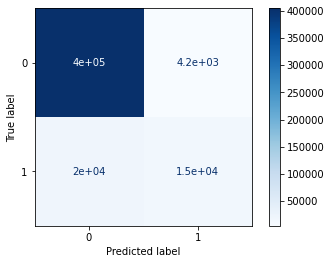

In [ ]:
plot_confusion_matrix(lr_best_model, X_val_tfvec, y_val, cmap='Blues')

Above is the confusion matrix for Logistic Regression. The data being imbalanced where most of the comments are non toxic, we get the highest number of correct predictions for non toxic comments, which is expected. However, the predictions for toxic comments is poor.

In [ ]:
preds = lr_best_model.predict(X_val_tfvec)

In [ ]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    409048
           1       0.79      0.43      0.56     35609

    accuracy                           0.95    444657
   macro avg       0.87      0.71      0.77    444657
weighted avg       0.94      0.95      0.94    444657



### Random Forest Classifier

In [ ]:
# Declare grid search parameters

rf_params = {
    'n_estimators':[100, 150, 190], 
    'class_weight': ['balanced'],
    'max_depth':[3, 4, 5],
    'random_state':[42]
}

rf_model = RandomForestClassifier()

rf_best_params, rf_best_model, rf_metrics = create_model(rf_model, params=rf_params)

print(rf_best_params)
print(rf_metrics)

{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 190, 'random_state': 42}
{'accuracy': 0.8340271265267386, 'recall': 0.6161925355949338, 'confusion_matrix': <function confusion_matrix at 0x7f4c1c9b59e0>, 'roc_auc_train': 0.8071052919496882, 'roc_auc_val': 0.7981347418047864}


In [ ]:
filename_rf = '/content/drive/My Drive/Capstone/Code/BaseModels/RandomForest.pkl'
pickle.dump(rf_best_model, open(filename_rf, 'wb'))

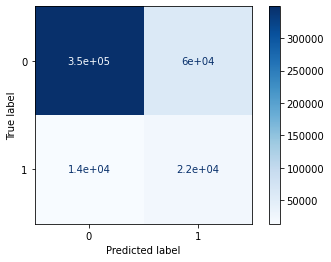

In [ ]:
plot_confusion_matrix(rf_best_model, X_val_tfvec, y_val, cmap='Blues')

Above is the confusion matrix for Random Forest. The data being imbalanced where most of the comments are non toxic, we get the highest number of correct predictions for non toxic comments, which is similar to logistic regression. However, the predictions for toxic comments is improved random forest as compared to logistic regression. Hence false negetive being lower than logistic regression.

In [ ]:
preds_rf = rf_best_model.predict(X_val_tfvec)

In [ ]:
print(classification_report(y_val, preds_rf))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90    409048
           1       0.27      0.62      0.37     35609

    accuracy                           0.83    444657
   macro avg       0.61      0.73      0.64    444657
weighted avg       0.91      0.83      0.86    444657



### ROC-AUC Curve

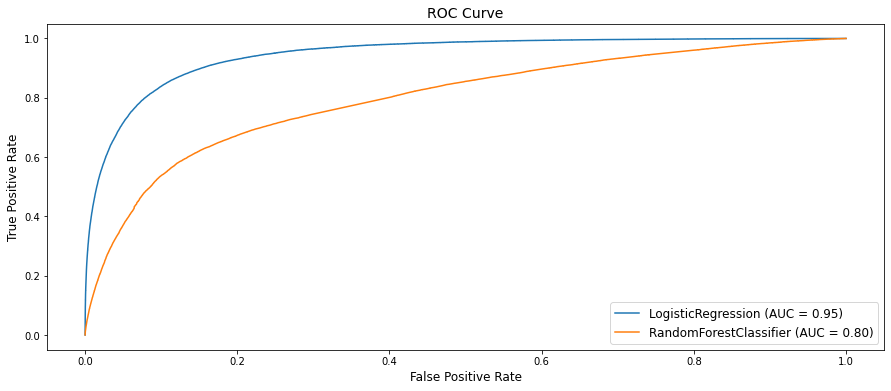

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
lr_disp = plot_roc_curve(lr_best_model, X_val_tfvec, y_val, ax=ax)
rf_disp = plot_roc_curve(rf_best_model, X_val_tfvec, y_val, ax=ax)
ax.set_title('ROC Curve', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12);

From the above roc auc, it seems that Logistic regression is performing better as it's AUC seems higher. However as mentioned previously we are going to give more weightage to recall as we would like to get high True Positives and low False Negetive. 

### Score Comparision

In [ ]:
scores = [['Logistic Regression', lr_metrics['roc_auc_train'], lr_metrics['roc_auc_val'], 
           lr_metrics['recall'], lr_metrics['accuracy']],
          ['Random Forest', rf_metrics['roc_auc_train'], rf_metrics['roc_auc_val'],  
           rf_metrics['recall'], rf_metrics['accuracy']]
          ['Bert', rf_metrics['roc_auc_train'], rf_metrics['roc_auc_val'],  
           rf_metrics['recall'], rf_metrics['accuracy']]]
print (tabulate(scores, headers=["", "Roc Auc Train", "Roc Auc Val", "Recall", "Accuracy"]))

                       Roc Auc Train    Roc Auc Val    Recall    Accuracy
-------------------  ---------------  -------------  --------  ----------
Logistic Regression         0.971497       0.945086  0.434974    0.94532
Random Forest               0.807105       0.798135  0.616193    0.834027


From the above score we can see that though accuracy for Logistic Regression is high, recall for Random Forest determines it is performing much better among the two. 

Let us explore the feature importance and see which words played important part in classifying the comments.

### Feature Importance

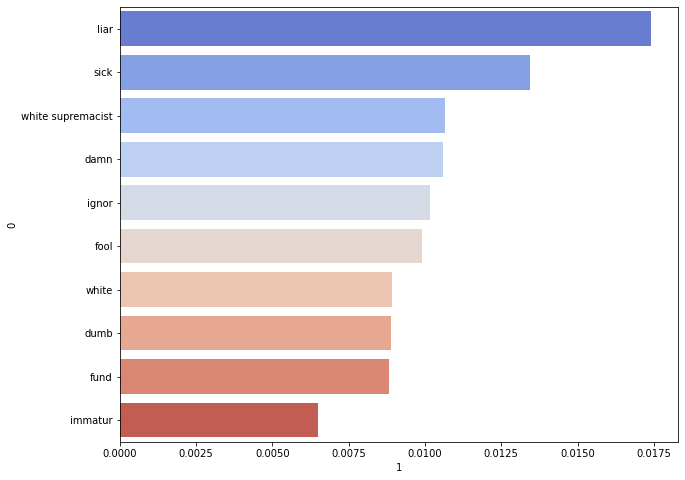

In [ ]:
# feature importance
def top10_features(best_model, title):
    features_list = tfvec.get_feature_names()

    feature_imp = best_model.feature_importances_
    
    feature_imp_df = pd.DataFrame([features_list, feature_imp])
    
    plt.figure(figsize=(10,8))
    sns.barplot(data=feature_imp_df.T.sort_values(by=1, ascending=False).head(10), y=0, x=1, orient='h', palette='coolwarm')

top10_features(rf_best_model, 'Feature Importance');

Here we saw the evaluation for Logistic Regression model and Random Forest model. However we will not conclude just yet. 
Next notebook contains training for BERT(Bidirectional Encoder Representations) which is a very powerful NLP model.